In [ ]:
# Predicting Customer Response to Marketing Campaigns
# This notebook explores customer response behavior using Random Forest for feature insights and Logistic Regression for prediction.


In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix)
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SequentialFeatureSelector


In [ ]:
# 2. Load and Inspect Data
filepath = '/content/marketing_campaign.csv'
data = pd.read_csv(filepath, sep='\t')
df = data.copy()
df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
# Basic Data Overview
df.info()
df.describe()
df.duplicated().sum()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

,0
ID,0
Year_Birth,0
Education,0
Marital_Status,0
Income,24
Kidhome,0
Teenhome,0
Dt_Customer,0
Recency,0
MntWines,0


In [ ]:
# 3. Data Cleaning and Feature Engineering

# Impute missing income with median
imputer = SimpleImputer(strategy='median')
df['Income'] = imputer.fit_transform(df[['Income']])

# Drop irrelevant or constant columns
df.drop(columns=['Z_CostContact', 'Z_Revenue','ID'], inplace=True)

# Create new features
df['Age'] = 2014 - df['Year_Birth']
df['TotalSpent'] = df[['MntWines', 'MntFruits', 'MntMeatProducts',
                       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
df['Children'] = df['Kidhome'] + df['Teenhome']

reference_date = pd.to_datetime('2014-12-31')
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)
df['Customer_Tenure_Years'] = ((reference_date - df['Dt_Customer']).dt.days / 365).round(2)

df['TotalAcceptedCampaigns'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                                   'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

df['TotalPurchases'] = df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

# Drop engineered-out columns
df.drop(columns=['Year_Birth', 'Kidhome', 'Teenhome', 'Dt_Customer',
                 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'], inplace=True)

# Check categorical variables
print("Education:")
print(df['Education'].unique())
print("\nMarital_Status:")
print(df['Marital_Status'].unique())

# Simplify categories
df['Education'] = df['Education'].replace({'2n Cycle': 'Master', 'Graduation': 'Bachelor'})
df['Marital_Status'] = df['Marital_Status'].replace({
    'Divorced': 'Single', 'Widow': 'Single', 'Absurd': 'Single',
    'YOLO': 'Single', 'Alone': 'Single'
})

# One-hot encode simplified categories
df = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True)


Education:
['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']

Marital_Status:
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


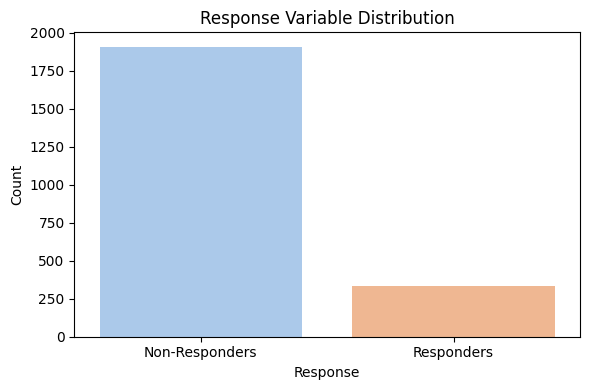

Class Distribution: Response
0    0.850893
1    0.149107
Name: proportion, dtype: float64


In [ ]:
# 4. Exploratory Data Analysis (EDA)

# Response distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Response', data=df, hue='Response', palette='pastel')
plt.legend().remove()
plt.title('Response Variable Distribution')
plt.xlabel('Response')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Responders', 'Responders'])
plt.tight_layout()
plt.show()

response_counts = df['Response'].value_counts(normalize=True)
print("Class Distribution:", response_counts)


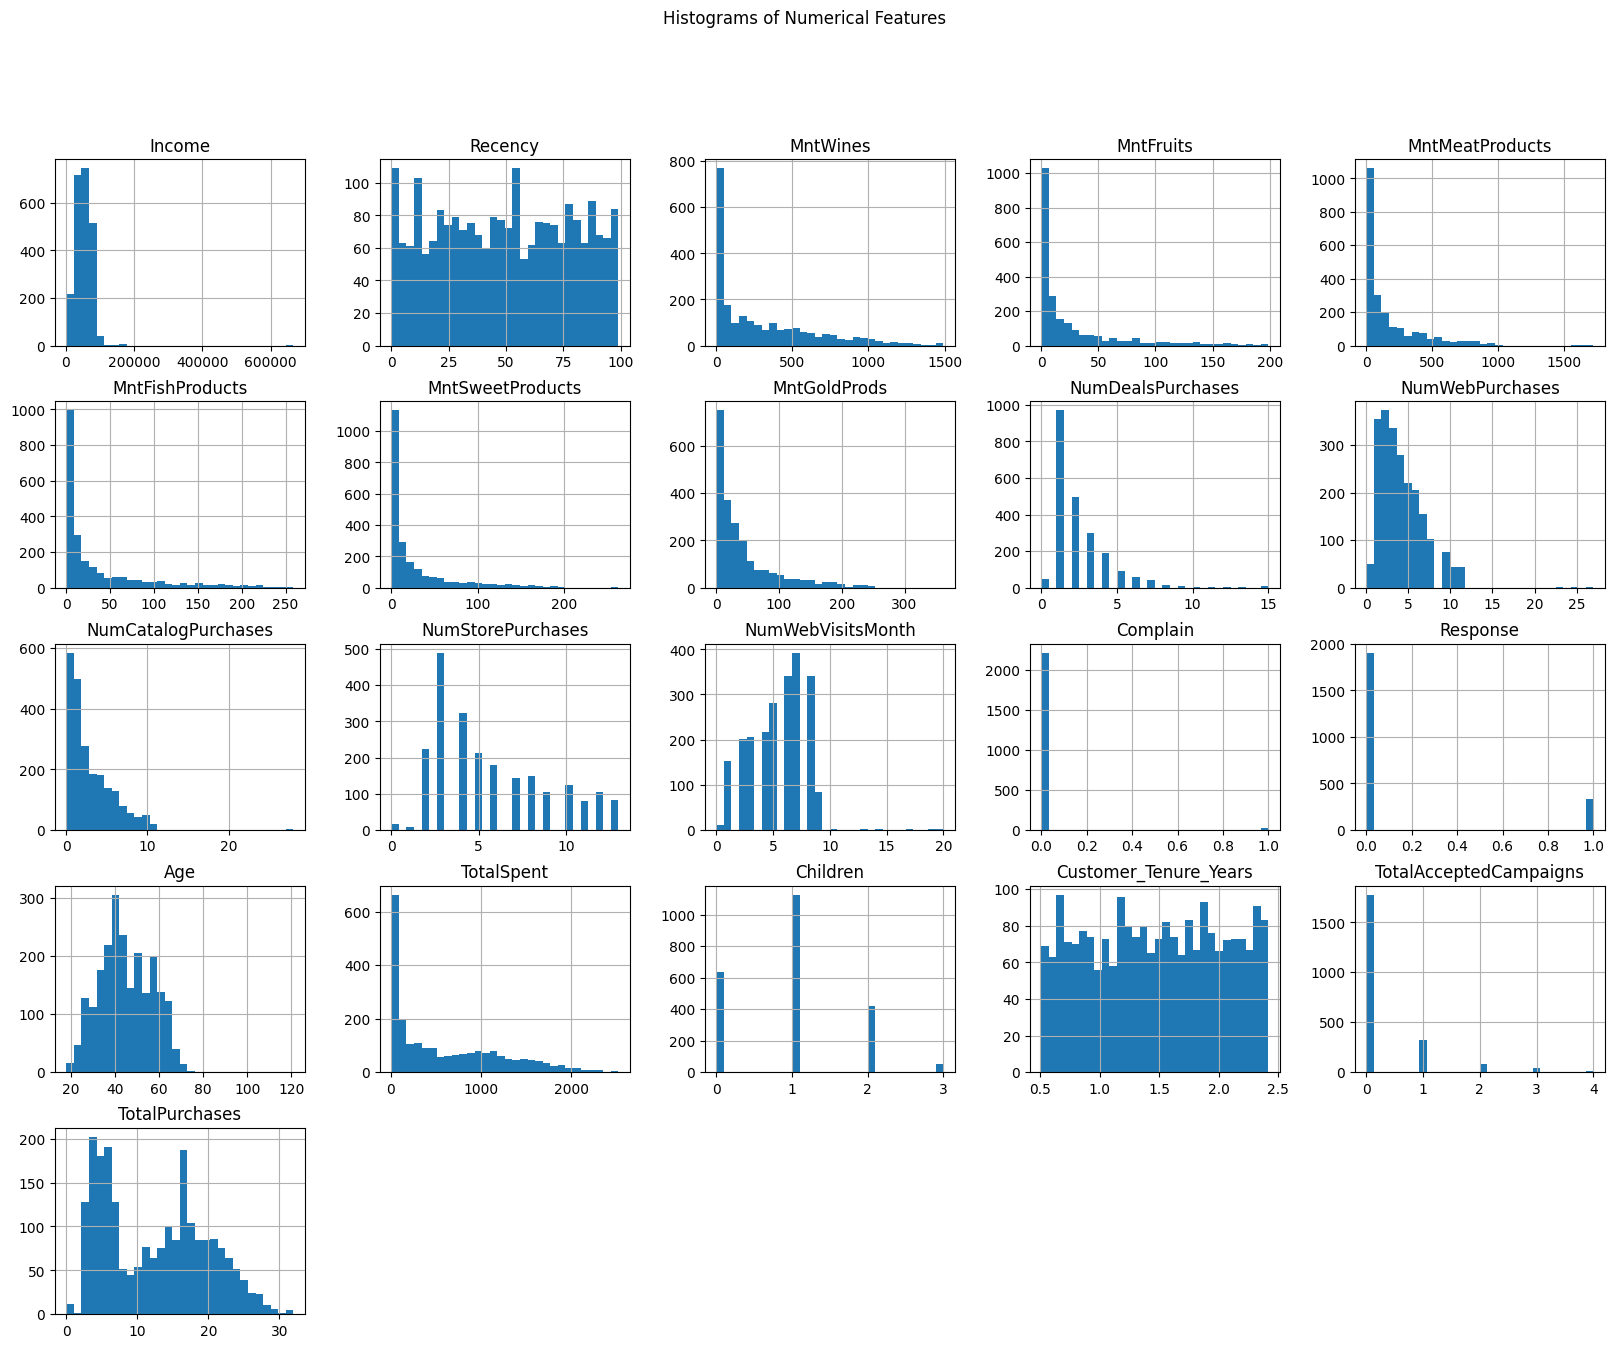

In [ ]:
# Histograms of all numeric features
df.select_dtypes(include=np.number).hist(bins=30, figsize=(20,15))
plt.suptitle('Histograms of Numerical Features')
plt.show()


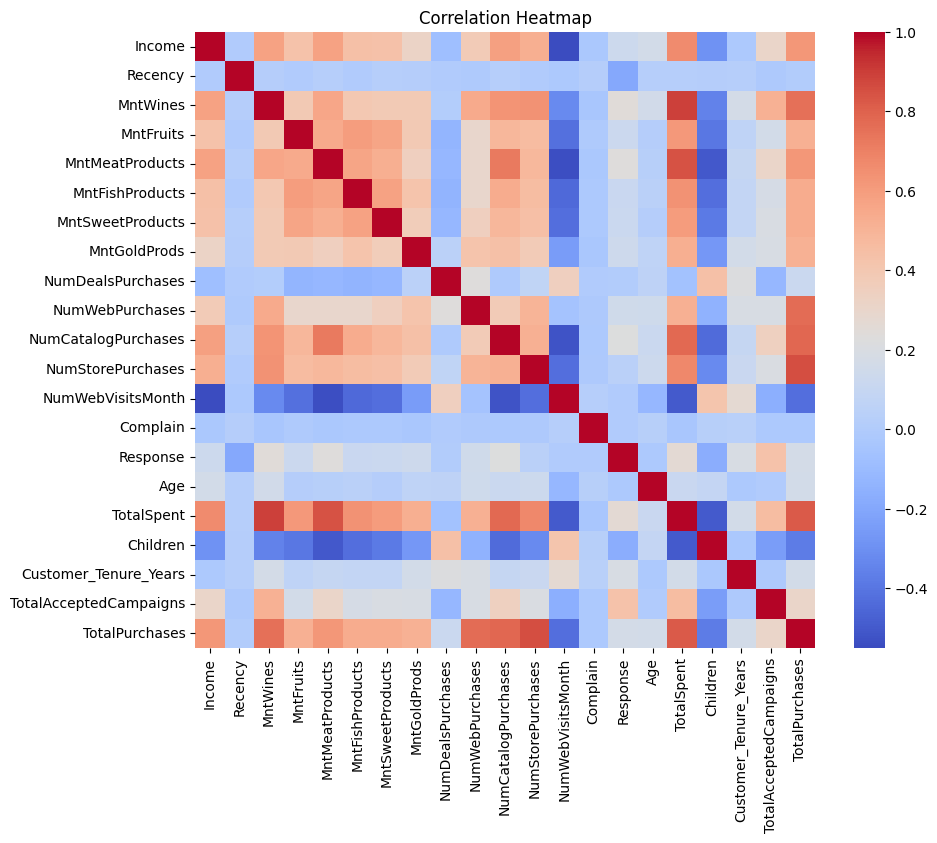

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()


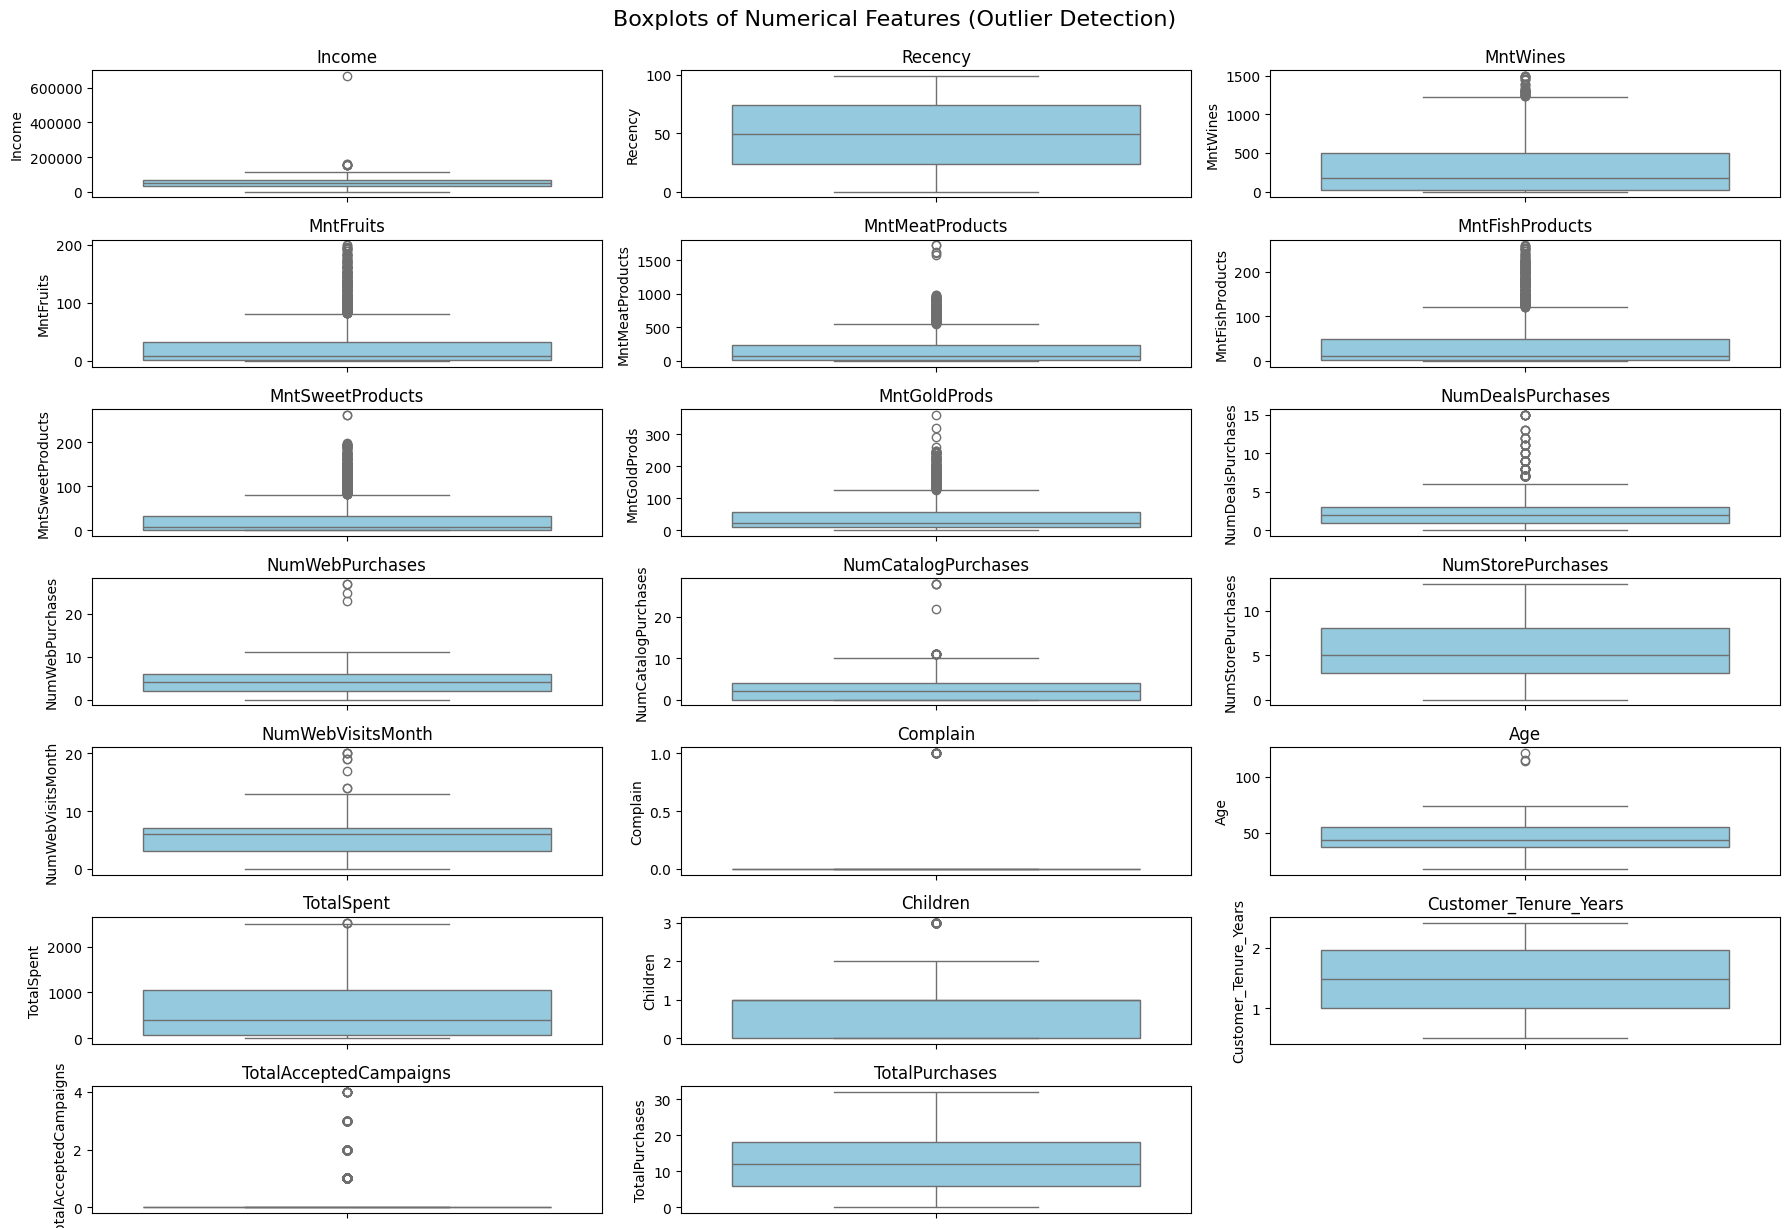

In [ ]:
# Boxplots for outlier detection
numeric_cols = df.select_dtypes(include=np.number).columns.drop('Response', errors='ignore')

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot((len(numeric_cols) // 3) + 1, 3, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()

plt.suptitle("Boxplots of Numerical Features (Outlier Detection)", y=1.02, fontsize=16)
plt.show()


In [ ]:
# 5. Outlier Handling and Transformation

# Log transform income to reduce skew
df['Income_log'] = np.log1p(df['Income'])
df.drop(columns='Income', inplace=True)
df.rename(columns={'Income_log': 'Income'}, inplace=True)

# Remove unrealistic outliers
df = df[df['Age'] <= 100]


In [ ]:
# 6. Train/Test Split and Scaling

numeric_cols = [
    'Income', 'Age', 'Customer_Tenure_Years', 'TotalSpent', 'TotalPurchases',
    'TotalAcceptedCampaigns', 'Children', 'MntWines', 'MntFruits', 'MntMeatProducts',
    'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'NumDealsPurchases', 'NumWebVisitsMonth', 'Recency'
]

# Separate features and target
X = df.drop(columns=['Response'])
y = df['Response']

# Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize numeric features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


In [ ]:
# 7. Feature Selection using Forward Selection (Logistic Regression)

sfs_logreg = SequentialFeatureSelector(
    LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    n_features_to_select=15,
    direction='forward',
    scoring='roc_auc',
    cv=5
)

sfs_logreg.fit(X_train, y_train)
selected_features = X_train.columns[sfs_logreg.get_support()].tolist()

# Reduce feature sets to selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
print("Selected features:", selected_features)


Selected features: ['Recency', 'MntWines', 'MntMeatProducts', 'NumDealsPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Complain', 'Children', 'Customer_Tenure_Years', 'TotalAcceptedCampaigns', 'TotalPurchases', 'Education_Basic', 'Education_PhD', 'Marital_Status_Single', 'Marital_Status_Together']


In [ ]:
# 8. Model Training and Cross-Validation

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_selected, y_train)

logreg_cv_scores = cross_val_score(logreg, X_train_selected, y_train, cv=5, scoring='roc_auc')
print("Logistic Regression CV AUC Scores:", logreg_cv_scores)
print(f"LogReg Mean AUC: {logreg_cv_scores.mean():.3f} ± {logreg_cv_scores.std():.3f}")


Logistic Regression CV AUC Scores: [0.91630065 0.85487164 0.89437135 0.92269737 0.911929  ]
LogReg Mean AUC: 0.900 ± 0.024


In [ ]:
# Random Forest (no feature selection)
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=10,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
print("Random Forest CV AUC Scores:", rf_cv_scores)
print(f"RF Mean AUC: {rf_cv_scores.mean():.3f} ± {rf_cv_scores.std():.3f}")


Random Forest CV AUC Scores: [0.91215589 0.81775441 0.87298977 0.89266569 0.88983366]
RF Mean AUC: 0.877 ± 0.032


In [ ]:
# Predict probabilities and labels
y_pred_logreg = logreg.predict(X_test_selected)
y_prob_logreg = logreg.predict_proba(X_test_selected)[:, 1]

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]


In [ ]:
# 9. Logistic Regression Evaluation (Threshold = 0.5)

precision = precision_score(y_test, y_pred_logreg)
recall = recall_score(y_test, y_pred_logreg)
f_score = f1_score(y_test, y_pred_logreg)
auc = roc_auc_score(y_test, y_prob_logreg)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_logreg).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("=== Logistic Regression ===")
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"F-score: {f_score:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")


=== Logistic Regression ===
Precision: 0.392
Recall (Sensitivity): 0.731
F-score: 0.510
AUC: 0.872
Sensitivity: 0.731
Specificity: 0.801


In [ ]:
# 10. Random Forest Evaluation (Threshold = 0.5)

precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f_score = f1_score(y_test, y_pred_rf)
auc = roc_auc_score(y_test, y_prob_rf)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("=== Random Forest ===")
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"F-score: {f_score:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")


=== Random Forest ===
Precision: 0.440
Recall (Sensitivity): 0.657
F-score: 0.527
AUC: 0.867
Sensitivity: 0.657
Specificity: 0.853


In [ ]:
# 11. Find Best Threshold for Random Forest Based on F1 Score

best_threshold = 0.5
best_f1 = 0
thresholds = np.arange(0.1, 0.91, 0.01)

for t in thresholds:
    y_pred_temp = (y_prob_rf >= t).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best Threshold for RF: {best_threshold:.2f} with F1: {best_f1:.3f}")


Best Threshold for RF: 0.53 with F1: 0.564


In [ ]:
# 12. Final Metrics at Best Threshold

y_pred_best_rf = (y_prob_rf >= best_threshold).astype(int)

precision = precision_score(y_test, y_pred_best_rf)
recall = recall_score(y_test, y_pred_best_rf)
f_score = f1_score(y_test, y_pred_best_rf)
auc = roc_auc_score(y_test, y_prob_rf)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_best_rf).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Random Forest (Best Threshold={best_threshold:.2f})")
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"F-score: {f_score:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")


Random Forest (Best Threshold=0.53)
Precision: 0.512
Recall (Sensitivity): 0.627
F-score: 0.564
AUC: 0.867
Sensitivity: 0.627
Specificity: 0.895


In [ ]:
# 13. Evaluation at Manual Threshold (e.g. 0.53 for higher precision)

threshold = 0.53
y_pred_rf_threshold = (y_prob_rf >= threshold).astype(int)

precision = precision_score(y_test, y_pred_rf_threshold)
recall = recall_score(y_test, y_pred_rf_threshold)
f_score = f1_score(y_test, y_pred_rf_threshold)
auc = roc_auc_score(y_test, y_prob_rf)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf_threshold).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Random Forest (Threshold={threshold})")
print(f"Precision: {precision:.3f}")
print(f"Recall (Sensitivity): {recall:.3f}")
print(f"F-score: {f_score:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Sensitivity: {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")


Random Forest (Threshold=0.53)
Precision: 0.512
Recall (Sensitivity): 0.627
F-score: 0.564
AUC: 0.867
Sensitivity: 0.627
Specificity: 0.895


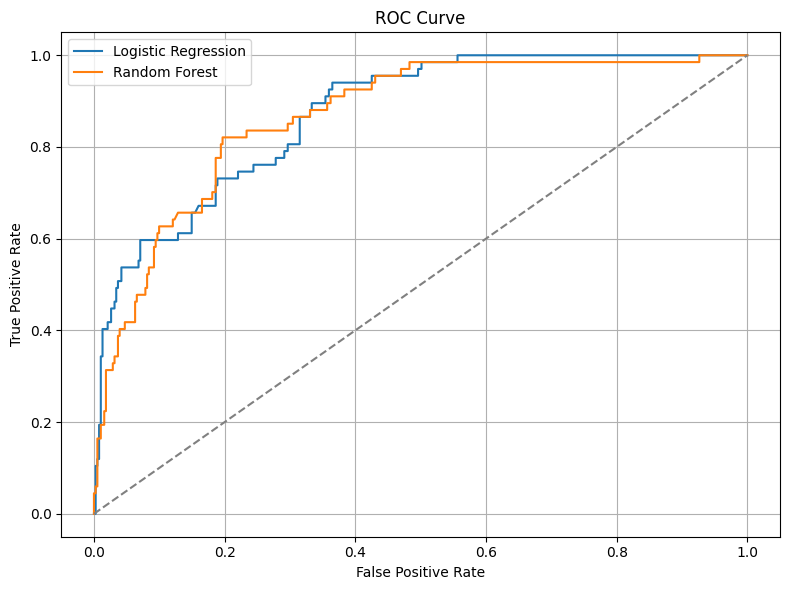

In [ ]:
# 14. ROC Curve Comparison

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_logreg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 15. Final Model Comparison Table

# Train set predictions
y_train_pred_logreg = logreg.predict(X_train_selected)
y_train_prob_logreg = logreg.predict_proba(X_train_selected)[:, 1]
auc_train_logreg = roc_auc_score(y_train, y_train_prob_logreg)
f1_train_logreg = f1_score(y_train, y_train_pred_logreg)

y_train_pred_rf_05 = rf.predict(X_train)
y_train_prob_rf = rf.predict_proba(X_train)[:, 1]
auc_train_rf = roc_auc_score(y_train, y_train_prob_rf)
f1_train_rf_05 = f1_score(y_train, y_train_pred_rf_05)

y_train_pred_rf_custom = (y_train_prob_rf >= threshold).astype(int)
f1_train_rf_custom = f1_score(y_train, y_train_pred_rf_custom)

# Test set already calculated earlier
auc_test_logreg = roc_auc_score(y_test, y_prob_logreg)
f1_test_logreg = f1_score(y_test, y_pred_logreg)

auc_test_rf = roc_auc_score(y_test, y_prob_rf)
f1_test_rf_05 = f1_score(y_test, y_pred_rf)
f1_test_rf_custom = f1_score(y_test, y_pred_rf_threshold)

# Final comparison table
comparison_df = pd.DataFrame({
    "Model": [
        "Logistic Regression (0.5)",
        "Random Forest (0.5)",
        f"Random Forest ({threshold})"
    ],
    "Train AUC": [auc_train_logreg, auc_train_rf, auc_train_rf],
    "Test AUC": [auc_test_logreg, auc_test_rf, auc_test_rf],
    "Train F1": [f1_train_logreg, f1_train_rf_05, f1_train_rf_custom],
    "Test F1": [f1_test_logreg, f1_test_rf_05, f1_test_rf_custom],
    "Threshold": [0.5, 0.5, threshold]
})

# Round and display
print("\nTrain vs Test Performance Comparison (All Models)")
print(comparison_df.round(3).to_string(index=False))



Train vs Test Performance Comparison (All Models)
                    Model  Train AUC  Test AUC  Train F1  Test F1  Threshold
Logistic Regression (0.5)      0.910     0.872     0.596    0.510       0.50
      Random Forest (0.5)      0.947     0.867     0.676    0.527       0.50
     Random Forest (0.53)      0.947     0.867     0.687    0.564       0.53


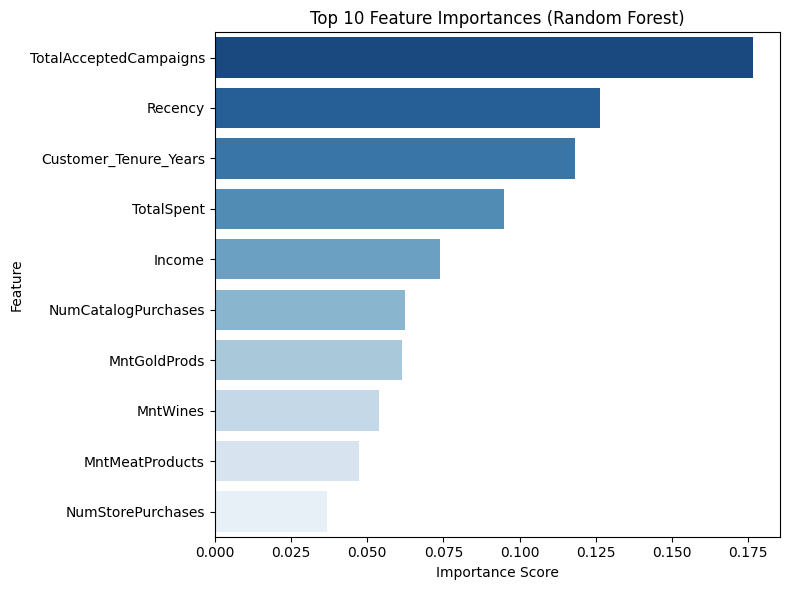

In [ ]:
# 16. Top Feature Importances from Random Forest

importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_rf = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_rf.values, y=top_rf.index, hue=top_rf.index, palette='Blues_r', legend=False)
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


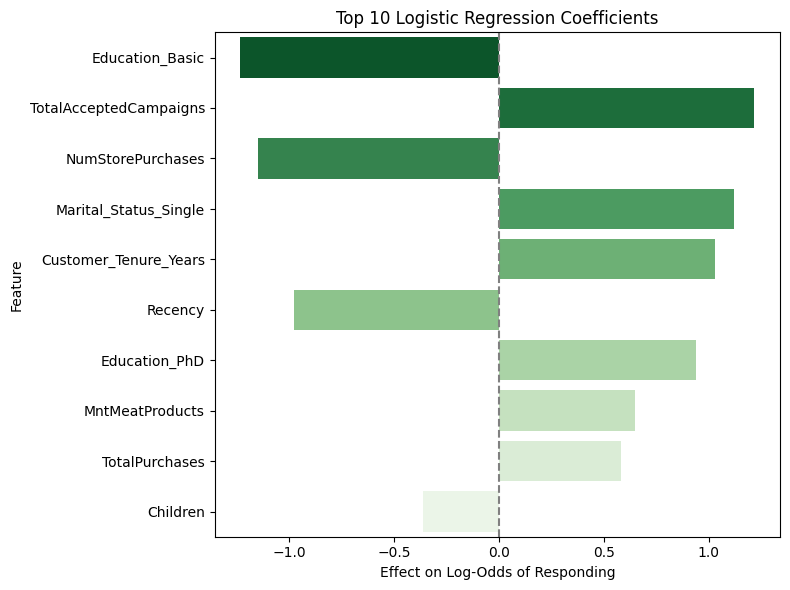

In [ ]:
# 17. Top absolute Coefficients from Logistic Regression

coef = pd.Series(logreg.coef_[0], index=X_train_selected.columns)
top_coef = coef.abs().sort_values(ascending=False).head(10)
top_signed = coef[top_coef.index]

plt.figure(figsize=(8, 6))
sns.barplot(
    x=top_signed.values,
    y=top_signed.index,
    hue=top_signed.index,
    palette='Greens_r',
    orient='h',
    legend=False)
plt.axvline(0, color='gray', linestyle='--')
plt.title('Top 10 Logistic Regression Coefficients')
plt.xlabel('Effect on Log-Odds of Responding')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


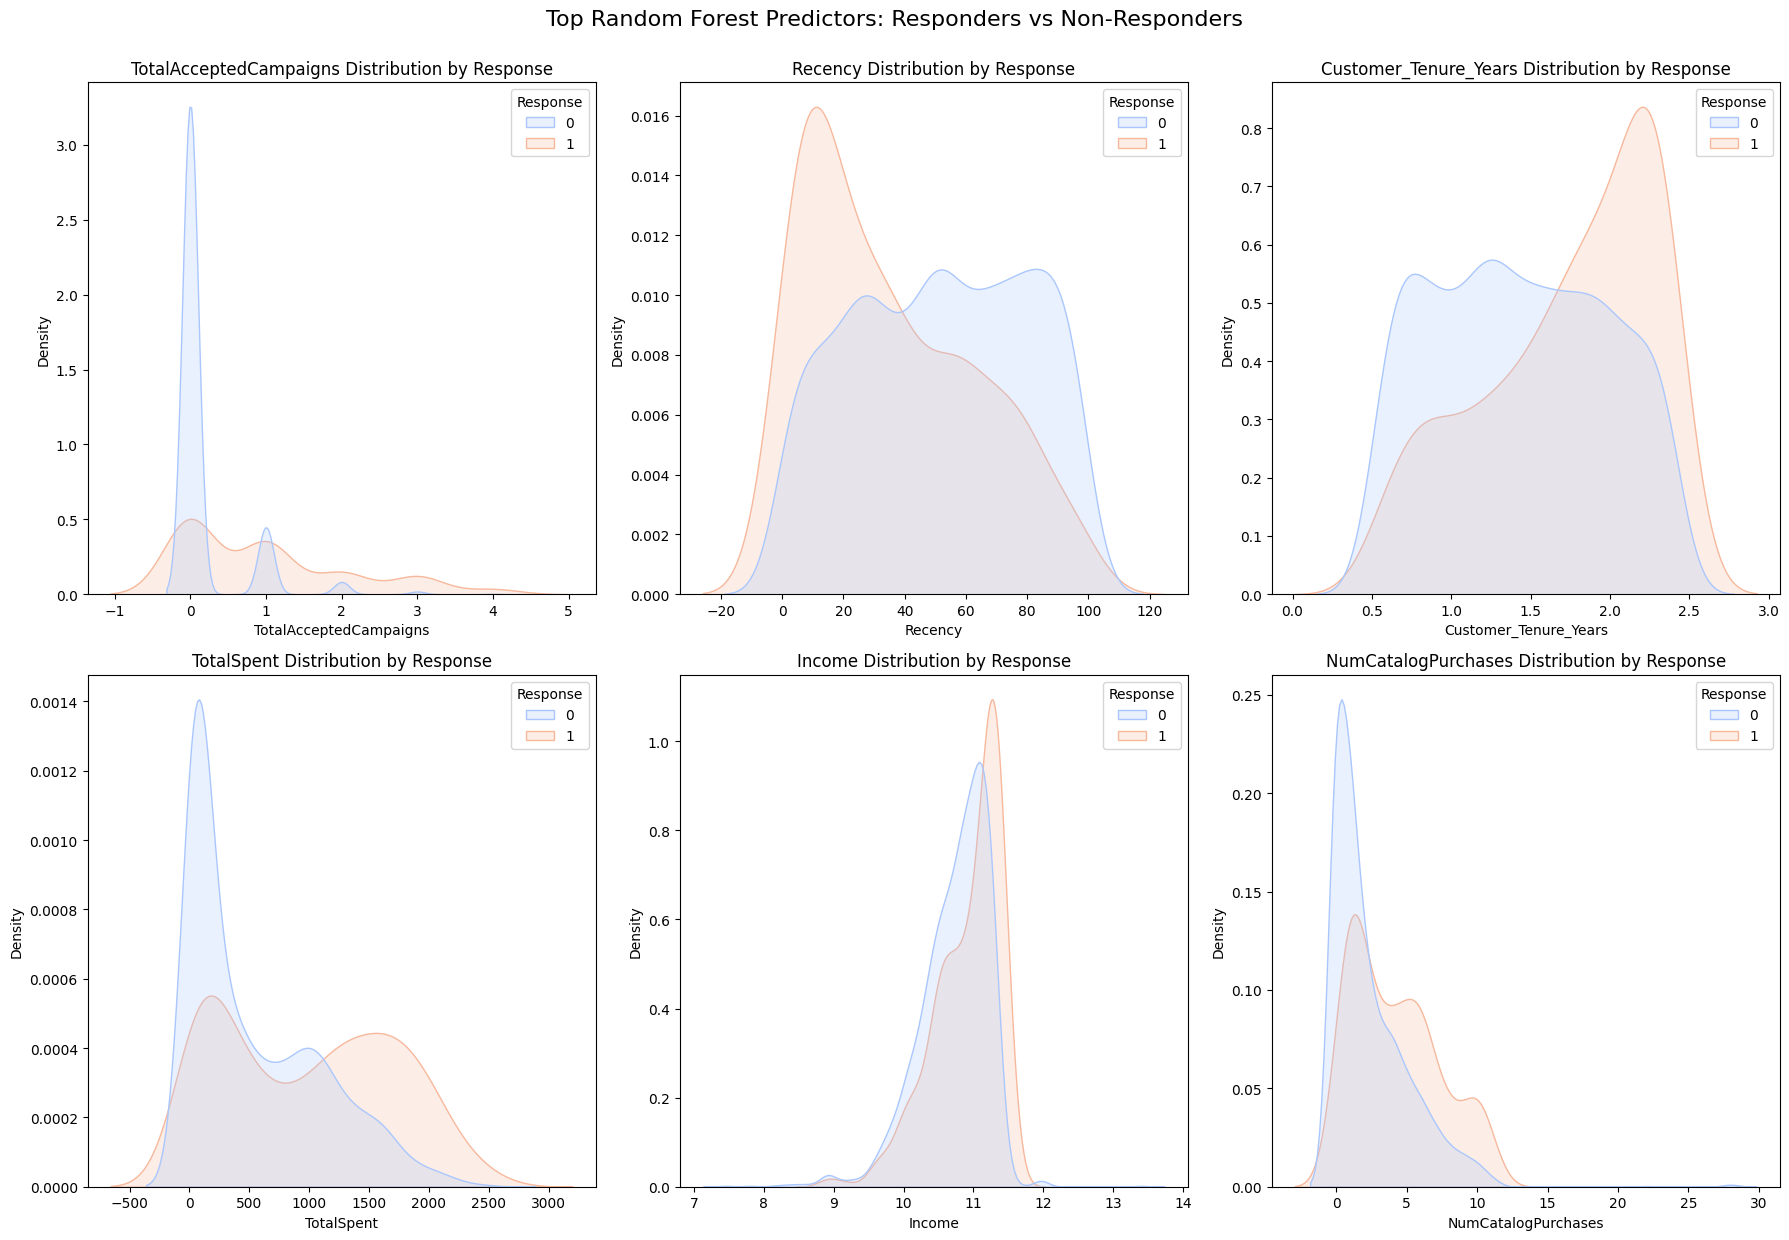

In [ ]:
# 18. Distribution of Top 6 Random Forest Features by Response

top_features = importances.sort_values(ascending=False).head(6).index.tolist()

plt.figure(figsize=(18, 12))
for i, col in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(data=df, x=col, hue='Response', fill=True, common_norm=False, palette='coolwarm')
    plt.title(f'{col} Distribution by Response')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.tight_layout()

plt.suptitle("Top Random Forest Predictors: Responders vs Non-Responders", fontsize=16, y=1.03)
plt.show()


In [ ]:
# 19. Customer Segmentation for Business Insight

df['TenureGroup'] = pd.cut(df['Customer_Tenure_Years'],
                           bins=[0, 0.5, 1, 2, 3.5],
                           labels=['<6mo', '6–12mo', '1–2yr', '2–3.5yr'])

df['RecencyGroup'] = pd.cut(df['Recency'],
                            bins=[0, 10, 30, 60, 90, 120],
                            labels=['0–10', '11–30', '31–60', '61–90', '91–120'])

df['CampaignGroup'] = pd.cut(df['TotalAcceptedCampaigns'],
                             bins=[-1, 0, 1, 2, 3, 5],
                             labels=['0', '1', '2', '3', '4–5'])

df['SpendingGroup'] = pd.qcut(df['TotalSpent'], 4)
df['LoyaltyGroup'] = pd.cut(df['Customer_Tenure_Years'], bins=[0, 1, 2, 3.5], labels=['<1yr', '1–2yr', '2–3.5yr'])


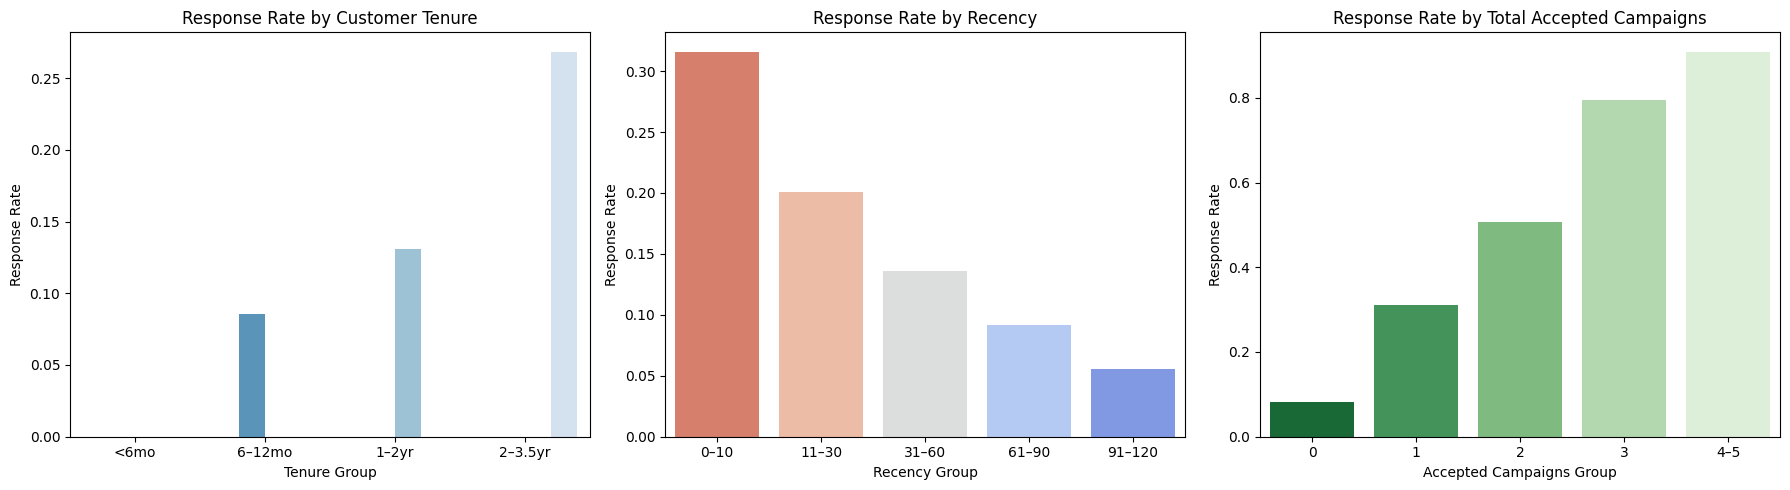

In [ ]:
# 20. Response Rate by Customer Segments

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(data=df, x='TenureGroup', y='Response', hue='TenureGroup', ax=axes[0],
            palette='Blues_r', legend=False, errorbar=None)
axes[0].set_title('Response Rate by Customer Tenure')
axes[0].set_ylabel('Response Rate')
axes[0].set_xlabel('Tenure Group')

sns.barplot(data=df, x='RecencyGroup', y='Response', hue='RecencyGroup', ax=axes[1],
            palette='coolwarm_r', legend=False, errorbar=None)
axes[1].set_title('Response Rate by Recency')
axes[1].set_ylabel('Response Rate')
axes[1].set_xlabel('Recency Group')

sns.barplot(data=df, x='CampaignGroup', y='Response', hue='CampaignGroup', ax=axes[2],
            palette='Greens_r', legend=False, errorbar=None)
axes[2].set_title('Response Rate by Total Accepted Campaigns')
axes[2].set_ylabel('Response Rate')
axes[2].set_xlabel('Accepted Campaigns Group')

plt.tight_layout()
plt.show()


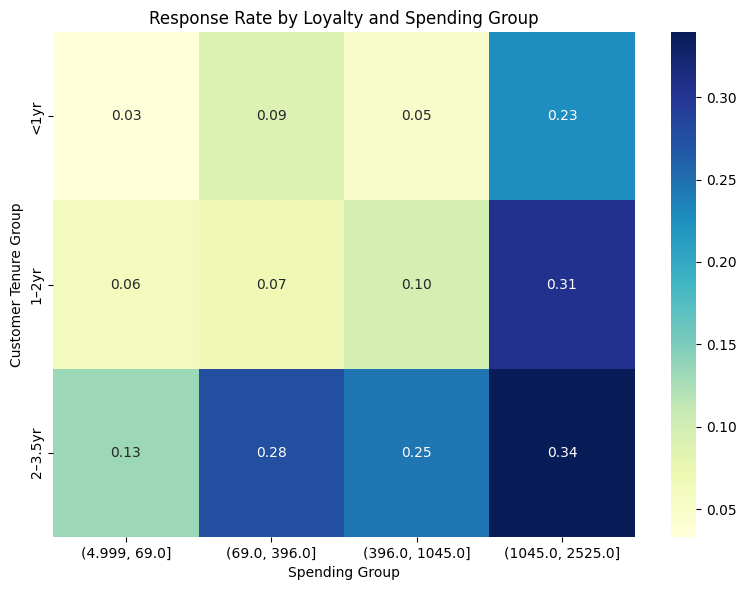

In [ ]:
# 21. Response Rate Heatmap by Loyalty and Spending Group

heatmap_data = df.groupby(['LoyaltyGroup', 'SpendingGroup'], observed=True)['Response'].mean().unstack()

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Response Rate by Loyalty and Spending Group')
plt.xlabel('Spending Group')
plt.ylabel('Customer Tenure Group')
plt.tight_layout()
plt.show()


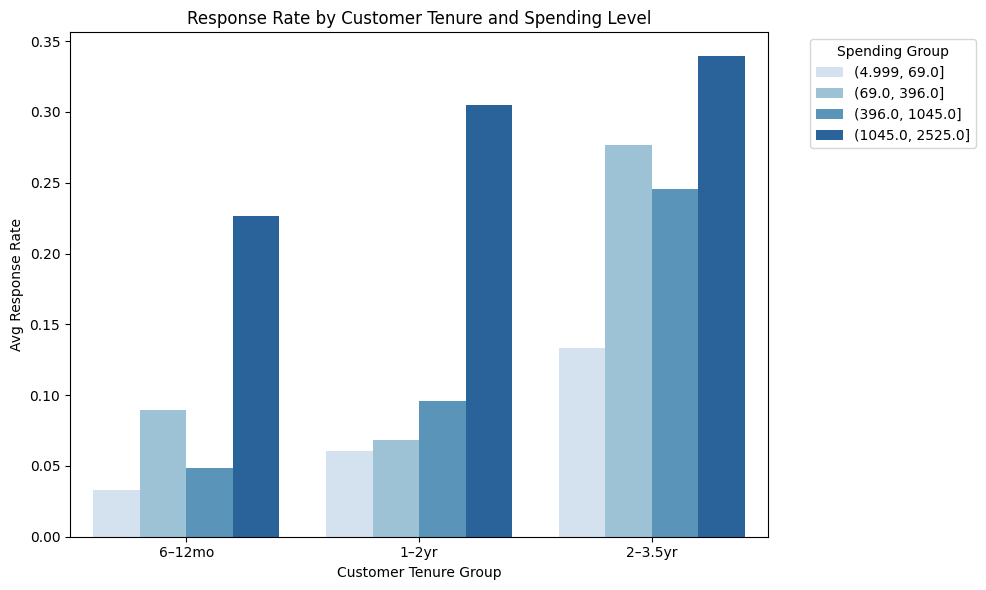

In [ ]:
# 22. Response Rate by TenureGroup and SpendingGroup

# Remove '<6mo' and drop unused category from TenureGroup
df_filtered = df[df['TenureGroup'] != '<6mo'].copy()
df_filtered['TenureGroup'] = df_filtered['TenureGroup'].cat.remove_categories(['<6mo'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_filtered,
    x='TenureGroup',
    y='Response',
    hue='SpendingGroup',
    errorbar=None,
    palette='Blues'
)

plt.title('Response Rate by Customer Tenure and Spending Level')
plt.xlabel('Customer Tenure Group')
plt.ylabel('Avg Response Rate')
plt.legend(title='Spending Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# 23. Top 10 Customers by Logistic Regression Prediction

# Reattach Customer_ID from original dataset
raw_df = pd.read_csv('/content/marketing_campaign.csv', sep='\t')
df['Customer_ID'] = raw_df['ID']

# Predict probabilities using logistic regression
df['Predicted_Probability_LogReg'] = logreg.predict_proba(df[X_train_selected.columns])[:, 1]

# Select columns to display
columns_to_show = [
    'Customer_ID', 'Predicted_Probability_LogReg', 'Customer_Tenure_Years', 'Recency',
    'TotalAcceptedCampaigns', 'MntMeatProducts', 'NumStorePurchases', 'NumCatalogPurchases',
    'TotalPurchases', 'NumWebPurchases', 'NumDealsPurchases', 'Children'
]

# Sort and extract top 10 customers
top_customers = df[columns_to_show].sort_values(by='Predicted_Probability_LogReg', ascending=False).head(10).copy()

# Round selected columns
round_cols = ['Predicted_Probability_LogReg', 'TotalPurchases']
top_customers[round_cols] = top_customers[round_cols].round(2)

# Rename columns for display
top_customers.rename(columns={
    'Customer_ID': 'ID',
    'Predicted_Probability_LogReg': 'Probability',
    'Customer_Tenure_Years': 'Tenure (Years)',
    'Recency': 'Recency (Days)',
    'TotalAcceptedCampaigns': 'Accepted Campaigns',
    'MntMeatProducts': 'Meat (€)',
    'NumStorePurchases': 'Store Purchases',
    'NumCatalogPurchases': 'Catalog Purchases',
    'TotalPurchases': 'Total Purchases',
    'NumWebPurchases': 'Web Purchases',
    'NumDealsPurchases': 'Deals Accepted',
    'Children': 'Dependents'
}, inplace=True)

# Reset index for display
top_customers.reset_index(drop=True, inplace=True)

# Display result
print("Top 10 Customers Most Likely to Respond to Campaign (Logistic Regression):")
print(top_customers)


Top 10 Customers Most Likely to Respond to Campaign (Logistic Regression):
      ID  Probability  Tenure (Years)  Recency (Days)  Accepted Campaigns  \
0   8720          1.0            2.39              53                   1   
1   5524          1.0            2.32              58                   0   
2  10469          1.0            0.90              42                   0   
3   1092          1.0            2.39              17                   0   
4  10968          1.0            2.10               0                   0   
5   1966          1.0            1.11              96                   1   
6   5376          1.0            1.98              42                   0   
7   8722          1.0            2.15              38                   2   
8   4418          1.0            1.85              36                   0   
9  10652          1.0            0.97              48                   0   

   Meat (€)  Store Purchases  Catalog Purchases  Total Purchases  \
0      16

### Final Notes

- Logistic Regression was chosen for deployment due to stronger test AUC and F1 stability.
- Top predictors were customer tenure, spending, and prior campaign acceptance.
- High-loyalty, high-spending segments showed the highest response rates.
- Business teams can use this model to prioritize customers and optimize campaign ROI.
